<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:**
- Zamarrón Álvarez, Ana Rosaura
- Castillejos Jauregui, Claudia Celeste

**Fecha:** 16 de febrero del 2023.

**Expediente** :
- 736222
- 735868
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Claudia0806/Tarea3_CCastillejos_AZamarron

# <font color= navy> Tarea 3

Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true

### <font color= navy> Alumno #1 

In [1]:
import pandas as pd

data = pd.read_excel('https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true')

data.head()

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230


In [2]:
data = data[['date','Energy (kWh)']]
data.head()

,date,Energy (kWh)
0,1990-01-01,498.632
1,1990-01-01,720.409
2,1990-01-01,946.154
3,1990-01-01,987.273
4,1990-01-01,1000.230


In [3]:
# Disminuimos la muestra de los datos.
data = data.set_index('date').resample('M').mean()


In [4]:
data.head()

,Energy (kWh)
date,
1990-01-31,451.887005
1990-02-28,423.897505
1990-03-31,430.298776
1990-04-30,296.197605
1990-05-31,288.352006


In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import MSTL
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class LinearForecast:
    def __init__(self, data):
        self.data = data

    def adf_test(self):
        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(self.data, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)

        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

        # Graficar ACF y PACF
    def plot_acf_pacf(self, kwargs=dict()):
        f = plt.figure(figsize=(8,5))

        ax1 = f.add_subplot(121)

        plot_acf(self.data, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(self.data, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()

    def descomposicion(self):
        data1 = self.data.copy()
        periods_seasonality = (6, 12)

        stl_kwargs = {"seasonal_deg": 0}
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()

        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()
        
        return res2
        
    def split_dataset(self):
        train_data, test_data = train_test_split(data, test_size=0.2, random_state=0, shuffle=False)

        return train_data, test_data

    def evaluate_forecasts(actual, predicted):
            
        mse = mean_squared_error(actual, predicted)
        rmse = mean_squared_error(actual, predicted, squared=True)
        mad = mean_absolute_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)

        return mse, rmse, mad, mape
    
    def model_forecast(self, history, data, p, d, q, start, end, horizonte=0):
        """
        Función que entrena y predice con el modelo entrenado un horizonte de tiempo HORIZONTE.
        :param history: Serie de tiempo con el cuál se entrenará el modelo. El tipo de dato tiene que estar acorde con el tipo de datos que reciba el modelo.
        """
        # Modelo de ARIMA
        arima_model = ARIMA(history, order=(p, d, q))
        model = arima_model.fit()
        print(model.summary())

        # Gráfico de los diagnósticos para los residuos
        plt.figure(figsize=(7,7))
        model.plot_diagnostics()
        plt.show()

        # Cómo realizar predicciones con el modelo ajustado
        model_func = model.predict(start=start, end=end + horizonte, dynamic=False).to_frame()
        ax = data.plot()
        model_func.plot(ax=ax)

        return model_func
    
    def evaluate_sarimax_params(self, sarimax_params):
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index=np.arange(0, 11))
        i = 0
        for par_no_esta, par_esta, trend in sarimax_params[200:210]:
            mod = SARIMAX(
                endog=self.data,
                trend=trend,
                order=par_no_esta,
                seasonal_order=par_esta
            )
            results = mod.fit(disp=False)

            resultados.loc[i, 'params'] = str((par_no_esta, par_esta, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1

        self.evaluated = resultados
        return resultados


In [6]:
lf = LinearForecast(data)

In [7]:
lf.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


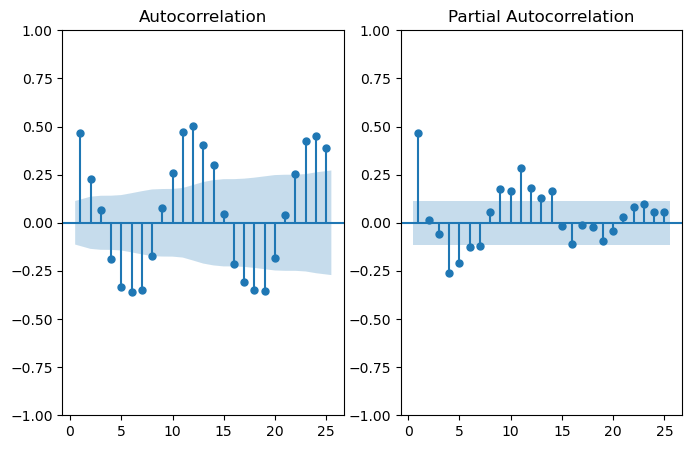

In [8]:
lf.plot_acf_pacf()

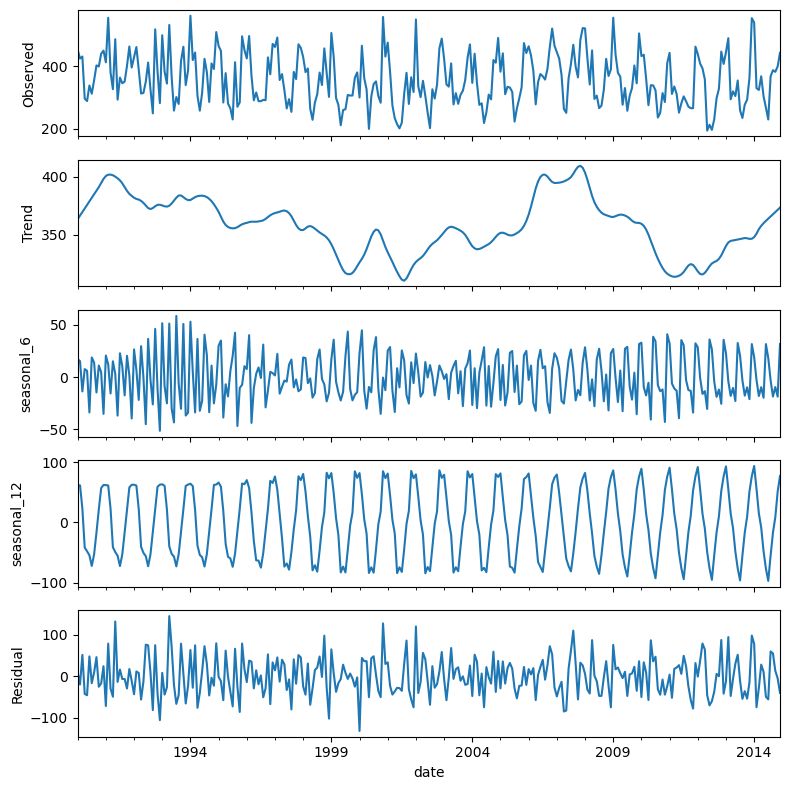

In [9]:
res3 = lf.descomposicion()

<AxesSubplot:xlabel='date'>

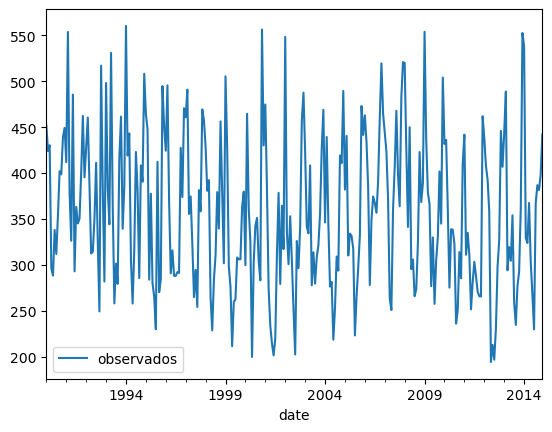

In [10]:
# Graficar datos observados con datos de estacionalidad
res3.observed.to_frame('observados').plot()

<AxesSubplot:xlabel='date'>

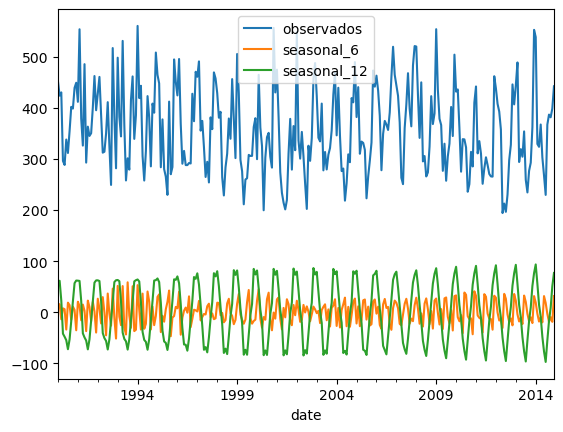

In [11]:
# Graficar datos observados con datos de estacionalidad
ax = res3.observed.to_frame('observados')[:400].plot()

res3.seasonal[:400].plot(ax=ax)

### Estacionariedad de la estacionalidad encontrada

In [12]:
#En base a la estacionalidad seleccionada, calcular la estacionariedad de dicha serie temporal
seasonality_6 = res3.seasonal['seasonal_6']
lf2 = LinearForecast(seasonality_6)
lf22 = LinearForecast(seasonality_6.diff().dropna())

lf2.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -9.451841e+00
p-value                        4.594080e-16
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary


In [13]:
lf22.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -1.483732e+01
p-value                        1.859822e-27
#Lags Used                     1.600000e+01
Number of Observations Used    2.820000e+02
Critical Value (1%)           -3.453754e+00
Critical Value (5%)           -2.871844e+00
Critical Value (10%)          -2.572261e+00
dtype: float64
Stationary


In [14]:
seasonality_12 = res3.seasonal['seasonal_12']
lf3 = LinearForecast(seasonality_12)
lf33= LinearForecast(seasonality_12.diff().dropna())
lf3.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                 -29.256349
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary


In [15]:
lf33.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                 -27.731064
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    282.000000
Critical Value (1%)             -3.453754
Critical Value (5%)             -2.871844
Critical Value (10%)            -2.572261
dtype: float64
Stationary


### Determinar parámetros (P,D,Q,S)

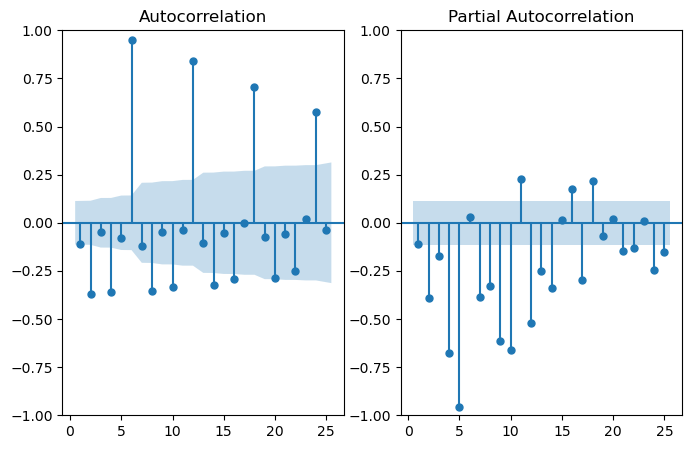

In [16]:
# Para los de 6 meses
lf2.plot_acf_pacf()

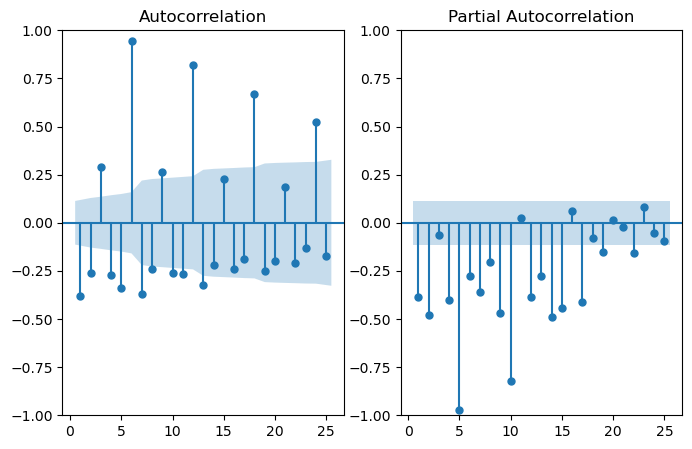

In [17]:
# Para los de 6 meses con una diferenciación
lf22.plot_acf_pacf()

<AxesSubplot:xlabel='date'>

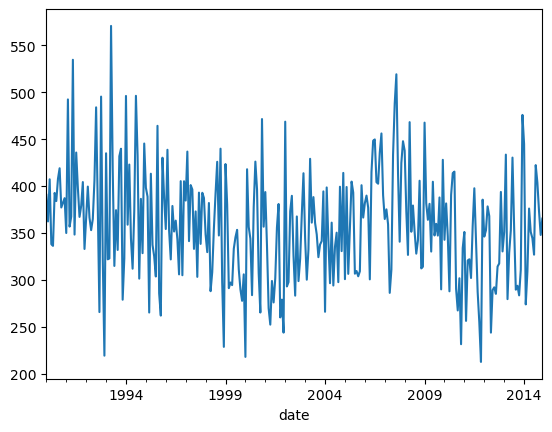

In [18]:
#3. Componente no estacional $(p, d, q)$
# Calcular la componente no estacional de la serie temporal
non_seasonal = res3.observed - res3.seasonal['seasonal_12']

non_seasonal.plot()

In [19]:
# Calcular si la serie no estacional es estacionaria o no
lf4 = LinearForecast(non_seasonal)
lf5 = LinearForecast(non_seasonal.diff().dropna())
lf4.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -4.543882
p-value                          0.000164
#Lags Used                       5.000000
Number of Observations Used    294.000000
Critical Value (1%)             -3.452790
Critical Value (5%)             -2.871422
Critical Value (10%)            -2.572035
dtype: float64
Stationary


In [20]:
lf5.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -7.204098e+00
p-value                        2.324421e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.820000e+02
Critical Value (1%)           -3.453754e+00
Critical Value (5%)           -2.871844e+00
Critical Value (10%)          -2.572261e+00
dtype: float64
Stationary


### Analisis de autocorrelación

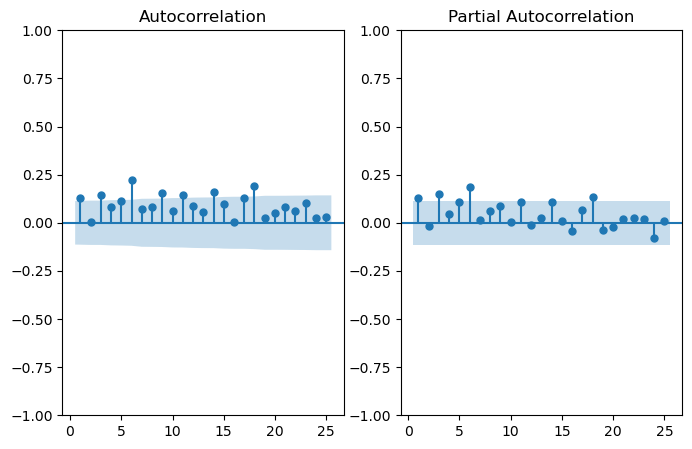

In [21]:
lf4.plot_acf_pacf()

In [22]:
import itertools

# Posibles valores en lo que pueden variar los parámetros de un SARIMAX
# Parte no estacional
p = [0, 1, 2, 3, 4]
d = [1]
q = [0, 1, 2, 3]
# Parte estacional
P = [0, 1, 2]
D = [0,1]
Q = [0, 1, 2]
# Tipo de tendencia
t = ['n', 'c', 't', 'ct']

#sarimax_params
param_no_estacionales = list(itertools.product(p, d, q))
param_estacionales = [(x[0], x[1], x[2], 6) for x in list(itertools.product(P, D, Q))]
sarimax_params = list(itertools.product(param_no_estacionales, param_estacionales, t))
sarimax_params

[((0, 1, 0), (0, 0, 0, 6), 'n'),
 ((0, 1, 0), (0, 0, 0, 6), 'c'),
 ((0, 1, 0), (0, 0, 0, 6), 't'),
 ((0, 1, 0), (0, 0, 0, 6), 'ct'),
 ((0, 1, 0), (0, 0, 1, 6), 'n'),
 ((0, 1, 0), (0, 0, 1, 6), 'c'),
 ((0, 1, 0), (0, 0, 1, 6), 't'),
 ((0, 1, 0), (0, 0, 1, 6), 'ct'),
 ((0, 1, 0), (0, 0, 2, 6), 'n'),
 ((0, 1, 0), (0, 0, 2, 6), 'c'),
 ((0, 1, 0), (0, 0, 2, 6), 't'),
 ((0, 1, 0), (0, 0, 2, 6), 'ct'),
 ((0, 1, 0), (0, 1, 0, 6), 'n'),
 ((0, 1, 0), (0, 1, 0, 6), 'c'),
 ((0, 1, 0), (0, 1, 0, 6), 't'),
 ((0, 1, 0), (0, 1, 0, 6), 'ct'),
 ((0, 1, 0), (0, 1, 1, 6), 'n'),
 ((0, 1, 0), (0, 1, 1, 6), 'c'),
 ((0, 1, 0), (0, 1, 1, 6), 't'),
 ((0, 1, 0), (0, 1, 1, 6), 'ct'),
 ((0, 1, 0), (0, 1, 2, 6), 'n'),
 ((0, 1, 0), (0, 1, 2, 6), 'c'),
 ((0, 1, 0), (0, 1, 2, 6), 't'),
 ((0, 1, 0), (0, 1, 2, 6), 'ct'),
 ((0, 1, 0), (1, 0, 0, 6), 'n'),
 ((0, 1, 0), (1, 0, 0, 6), 'c'),
 ((0, 1, 0), (1, 0, 0, 6), 't'),
 ((0, 1, 0), (1, 0, 0, 6), 'ct'),
 ((0, 1, 0), (1, 0, 1, 6), 'n'),
 ((0, 1, 0), (1, 0, 1, 6), 'c'),
 ((

### Transformación logarítmica 

<AxesSubplot:>

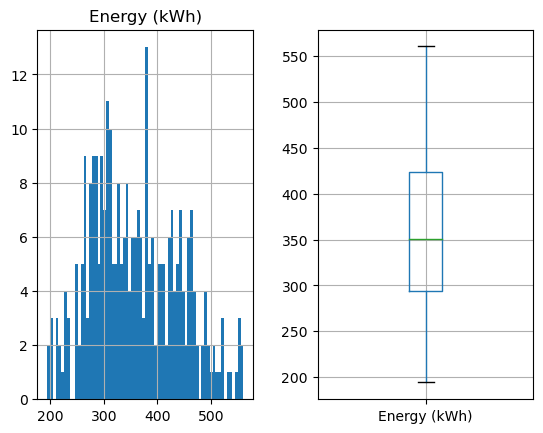

In [23]:
# Obtener histograma con la transformación logarítmica y sqrt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2)
data.hist(bins=70, ax=ax[0])
data.boxplot(ax=ax[1])

In [24]:
train, test = lf.split_dataset()

In [25]:
import numpy as np
data['ln_y'] = np.log(train['Energy (kWh)'])

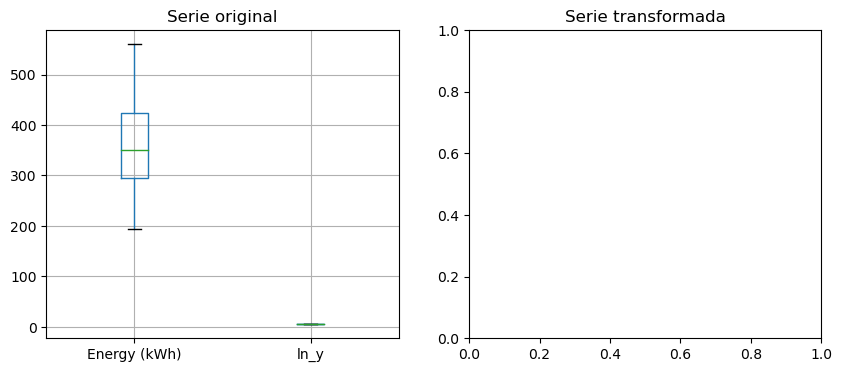

In [26]:
# Calcular el boxplot antes y después de la transformación
fig, ax = plt.subplots(1, 2, figsize=(10,4))
data.boxplot(ax=ax[0])
ax[0].set_title('Serie original')


ax[1].set_title('Serie transformada')
plt.show()

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
lf7 = LinearForecast(train)
lf7.evaluate_sarimax_params(sarimax_params)

C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Castillejos\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\U

,params,AIC,BIC,LLF
0,"((0, 1, 2), (2, 0, 2, 6), 'n')",2665.905763,2690.241008,-1325.952882
1,"((0, 1, 2), (2, 0, 2, 6), 'c')",2674.304692,2702.1164,-1329.152346
2,"((0, 1, 2), (2, 0, 2, 6), 't')",2705.758449,2733.570157,-1344.879224
3,"((0, 1, 2), (2, 0, 2, 6), 'ct')",2704.490481,2735.778653,-1343.245241
4,"((0, 1, 2), (2, 1, 0, 6), 'n')",2710.046488,2727.30168,-1350.023244
5,"((0, 1, 2), (2, 1, 0, 6), 'c')",2711.828058,2732.534289,-1349.914029
6,"((0, 1, 2), (2, 1, 0, 6), 't')",2711.833309,2732.539539,-1349.916654
7,"((0, 1, 2), (2, 1, 0, 6), 'ct')",2762.01808,2786.17535,-1374.00904
8,"((0, 1, 2), (2, 1, 1, 6), 'n')",2668.199522,2688.905753,-1328.099761
9,"((0, 1, 2), (2, 1, 1, 6), 'c')",2667.193628,2691.350897,-1326.596814


El mejor modelo es el de los parámetros (0, 1, 2), (2, 0, 2, 6), 'n'